# Notebook #5: Serie temporal: Prophet

In [2]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('../..')
from src import soporte_temporales as st
from src import soporte_sarima as ss
from src import soporte_funciones_BBDD as sfbd
from src import soporte_variables_defunciones as svd

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Calcular métricas
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

# Query para traer datos agrupados

In [3]:
df_defunciones = sfbd.dbeaver_fetch(sfbd.dbeaver_conexion("proyecto_final"),svd.query_EDA_1)

# Defunciones

In [5]:
df_copia = df_defunciones.copy()
df_copia['fecha'] = pd.to_datetime(df_copia['fecha'])
df_copia["Month"] = df_copia["fecha"].dt.month_name()
df_copia["Year"] = df_copia["fecha"].dt.year
df_copia.head()

,fecha,casos_defunciones,Month,Year
0,2007-01-01,146,January,2007
1,2007-02-01,136,February,2007
2,2007-03-01,156,March,2007
3,2007-04-01,147,April,2007
4,2007-05-01,117,May,2007


In [6]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_copia, temporal_column="fecha", value_column="casos_defunciones")

analisis_st.exploracion_datos()

El número de filas es 204 y el número de columnas es 3

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
casos_defunciones,204,154,25,77,137,153,169,208
Year,204,2015,5,2007,2011,2015,2019,2023


In [7]:
analisis_st.comprobar_serie_continua()

La serie temporal es continua para la frecuencia 'M', no faltan periodos.


In [8]:
analisis_st.graficar_serie()

### Análisis de la Serie Temporal de Accidentes

La gráfica ilustra una **serie temporal de defunciones** con valores que oscilan entre 80 y 200, mostrando comportamientos interesantes que merecen ser destacados.

#### Observaciones clave:

1. **Patrones cíclicos y estacionalidad**:
   - Se aprecian **picos regulares** en ciertos meses, lo que sugiere una **estacionalidad** marcada. Esto podría estar vinculado a eventos como:
     - Festividades o vacaciones, donde la movilización aumenta.
     - Cambios estacionales que pueden influir en las condiciones de tránsito.

2. **Ausencia de tendencia de largo plazo**:
   - La serie temporal no muestra un patrón de crecimiento o disminución sostenida a lo largo de los años.
   - Sin embargo, la **oscilación alrededor de una media aparente** indica que las defunciones fluctúan de forma consistente en un rango determinado.

3. **Período 2016-2020**:
   - Este período destaca por una **caída pronunciada** en las defunciones, seguida de un aumento acelerado.
   - En **2020**, se observa una caída significativa en las cifras, que puede estar asociada a:
     - **Restricciones de movilidad** impuestas durante la pandemia de COVID-19.
     - Una menor actividad social y económica durante este tiempo.

4. **Restablecimiento posterior a 2020**:
   - A partir de finales de **2020** y durante **2021-2022**, las cifras comienzan a estabilizarse, recuperándose hacia los valores históricos.
   - Esto sugiere una **vuelta a la normalidad** en términos de movilidad y comportamiento social.

5. **Variabilidad mensual significativa**:
   - Las fluctuaciones de un mes a otro son notables, lo que indica que no solo hay estacionalidad, sino que también pueden influir eventos específicos o variaciones puntuales en la movilidad.


In [9]:
analisis_st.graficar_media_movil(window=12)

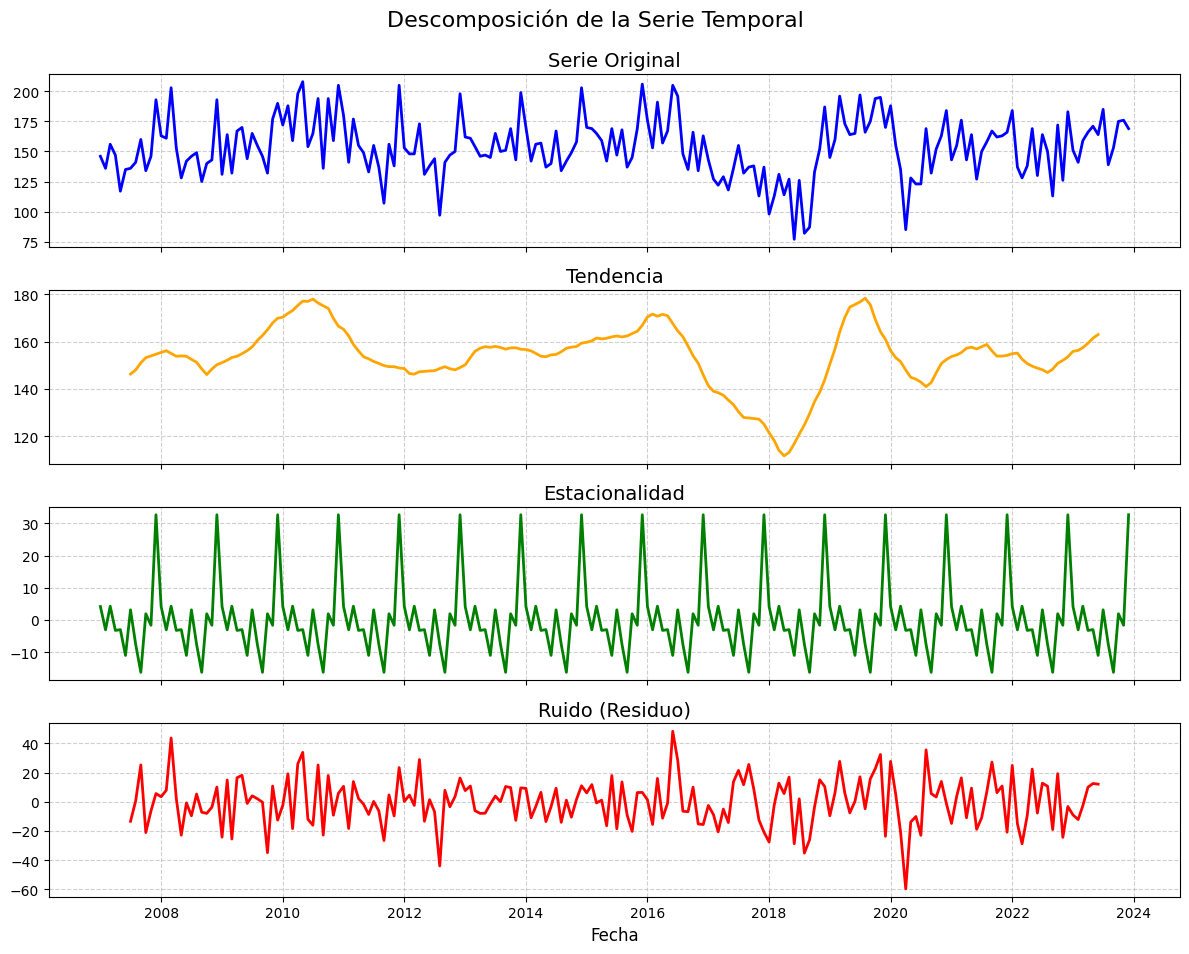

In [10]:
analisis_st.detectar_estacionalidad()

# Análisis de autocorrelación

<Figure size 1200x1000 with 0 Axes>

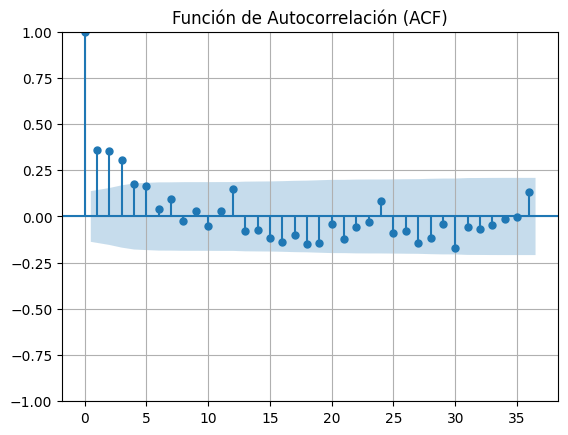

<Figure size 1200x1000 with 0 Axes>

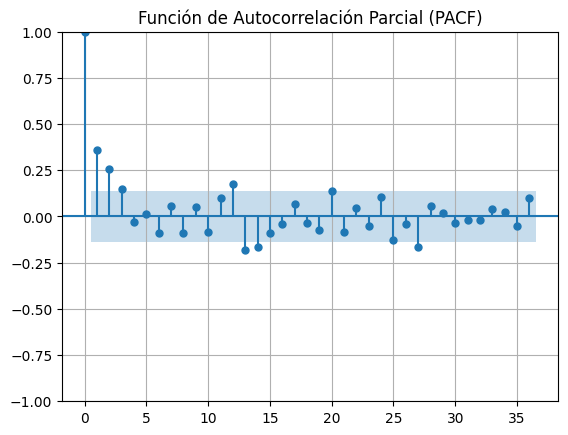

In [11]:
analisis_st.graficar_acf_pacf(lags=36)

## Interpretación de los lags

## Análisis de las Gráficas ACF y PACF

### **Gráfica ACF (Función de Autocorrelación)**
1. **Lag 1**:
   - La correlación en el primer lag es muy alta (cercana a 0.75), lo que indica que la variable tiene una fuerte relación con su valor del periodo inmediatamente anterior.
   
2. **Lags significativos**:
   - Los lags 2 y 3 tienen correlaciones significativas que sobresalen del intervalo de confianza, lo que sugiere que también tienen impacto en la serie.
   - Después del tercer lag, las correlaciones disminuyen gradualmente y se acercan al intervalo de confianza.

3. **Tendencia a cero**:
   - La autocorrelación disminuye de manera lenta y persistente, lo que podría ser indicativo de no estacionaridad o una estructura autorregresiva en la serie.

4. **Estacionalidad**:
   - Se presenta un pico cada 12 lags, lo que sugiere un patrón anual. Este rebote es lo que demuestra la estacionalidad de la serie   
---

### **Gráfica PACF (Función de Autocorrelación Parcial)**
1. **Lag 1**:
   - El primer lag muestra una correlación significativa (cercana a 0.75), indicando que el valor actual está altamente influenciado por el valor del periodo inmediatamente anterior.

2. **Lags significativos**:
   - Los lags 2 y 3 también son significativos, aunque con menor intensidad, lo que indica que las correlaciones directas entre estos lags y el valor actual son importantes.

3. **Lags posteriores**:
   - A partir del lag 4, las barras caen dentro del intervalo de confianza, lo que implica que los lags más lejanos no tienen una influencia directa significativa.

---

In [12]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -3.6734269015355294
p-value: 0.004502839670564938
Valores Críticos:
1%: -3.4652439354133255
5%: -2.8768752281673717
10%: -2.574944653739612
Rechazamos la hipótesis nula. La serie es estacionaria.


    - La serie es estacionaria de acuerdo al ADF Test.

## Modelo usando Prophet

### Convertir las columnas para que sean legibles por Prophet

In [13]:
df_defunciones.columns = ['ds', 'y']

In [14]:
df_defunciones.tail()

,ds,y
199,2023-08-01,139
200,2023-09-01,153
201,2023-10-01,175
202,2023-11-01,176
203,2023-12-01,169


## Predicción de los valores actuales y a futuro

In [15]:
m = Prophet()
m.fit(df_defunciones)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=24, freq='MS') 
m.predict(df_defunciones)

16:27:50 - cmdstanpy - INFO - Chain [1] start processing
16:27:50 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-01-01,156,131,187,156,156,4,4,4,4,4,4,0,0,0,159
1,2007-02-01,156,125,180,156,156,-4,-4,-4,-4,-4,-4,0,0,0,152
2,2007-03-01,155,133,188,155,155,4,4,4,4,4,4,0,0,0,160
3,2007-04-01,155,125,180,155,155,-2,-2,-2,-2,-2,-2,0,0,0,153
4,2007-05-01,155,126,180,155,155,-4,-4,-4,-4,-4,-4,0,0,0,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2023-08-01,152,114,169,152,152,-9,-9,-9,-9,-9,-9,0,0,0,143
200,2023-09-01,152,108,165,152,152,-16,-16,-16,-16,-16,-16,0,0,0,135
201,2023-10-01,151,126,182,151,151,3,3,3,3,3,3,0,0,0,155
202,2023-11-01,151,126,180,151,151,0,0,0,0,0,0,0,0,0,152


In [16]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
223,2025-08-01,143,116,172
224,2025-09-01,136,110,164
225,2025-10-01,154,126,179
226,2025-11-01,151,123,179
227,2025-12-01,183,155,213


In [17]:
df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df['defunciones'] = df_defunciones['y']
df = df[df['defunciones'].notnull() & df['yhat'].notnull()]
df.tail(5)

,ds,yhat,yhat_lower,yhat_upper,defunciones
199,2023-08-01,143,115,170,139
200,2023-09-01,135,107,164,153
201,2023-10-01,155,127,182,175
202,2023-11-01,152,123,180,176
203,2023-12-01,183,154,212,169


### Métricas de mi modelo - Prophet

## Insights de las Métricas del Modelo Prophet

### **MAE: 16.81**
- El **MAE (Error Absoluto Medio)** indica que el modelo comete, en promedio, un error absoluto de **16.81 casos de defunciones al mes**.
- Comparado con los valores reales (que oscilan entre 100 y 200), este es un error bajo y sugiere que el modelo tiene un buen ajuste.

### **MAPE: 11.77%**
- Un **MAPE (Error Absoluto Porcentual Medio)** del **11.77%** significa que el modelo tiene un error relativo de alrededor del **12%** en sus predicciones.
- Esto se considera un buen desempeño, ya que un MAPE por debajo del **15%** es generalmente aceptable en aplicaciones prácticas. Refleja que el modelo es confiable para capturar patrones de la serie temporal.

### **RMSE: 21.81**
- El **RMSE (Raíz del Error Cuadrático Medio)** penaliza más los errores grandes, y su valor de **21.81** está alineado con el MAE, lo que indica que no hay errores extremos en las predicciones.
- Este valor refuerza que el modelo es consistente y no genera desviaciones significativas respecto a los datos reales.

---

In [18]:
y_real = df['defunciones']
y_pred = df['yhat']

# calcular métricas
mae = mean_absolute_error(y_real, y_pred)
mape = mean_absolute_percentage_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))

# resultados
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse}")

MAE: 16.811434077383815
MAPE: 11.77%
RMSE: 21.806114837171673


## Distribución gráfica de los valores reales, sus predicciones y las predicciones a futuro

- Se observa el comportamiento a del modelo, comparando los valores reales con los predichos. Además, presenta el comportamiento que siguen las predicciones a futuro.

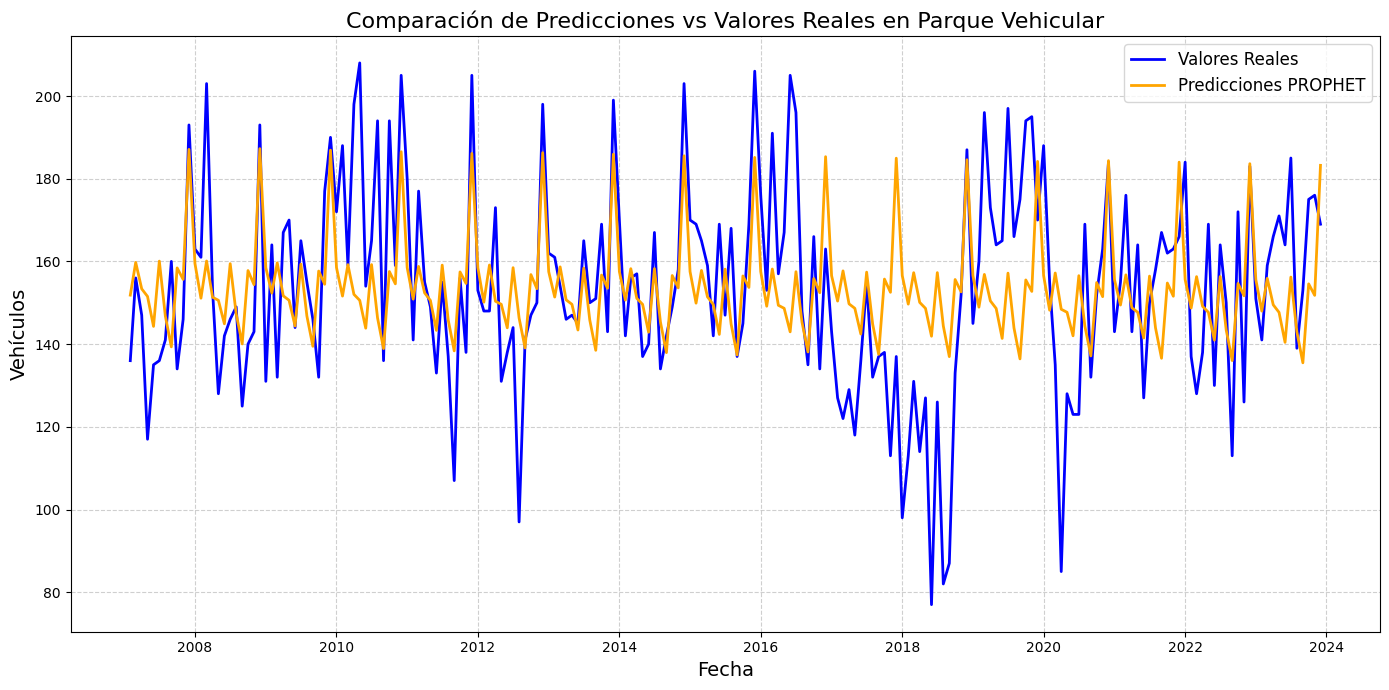

In [22]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df[1:], x="ds", y="defunciones", label="Valores Reales", color="blue", linewidth=2) # valores reales
sns.lineplot(data=df[1:], x="ds", y="yhat", label="Predicciones PROPHET", color="orange", linewidth=2) # predicciones
plt.title("Comparación de Predicciones vs Valores Reales en Parque Vehicular", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Vehículos", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6) # formato cuadriculado
plt.tight_layout()
plt.show()

In [20]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

## Tendencias

In [21]:
plot_components_plotly(m, forecast)

- En la parte superior, se observa el comportamiento a largo plazo del modelo, indicando una **tendencia descendente**. En otras palabras, las defunciones están disminuyendo con el tiempo.

- En la parte inferior, se muestra la **estacionalidad anual** del modelo. Se pueden identificar picos y caídas recurrentes. Es evidente que el aumento en las defunciones ocurre consistentemente durante las épocas festivas, como los meses de **noviembre y diciembre**.
